In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python==4.5.5.64

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


In [ ]:
!pip show opencv-python

Name: opencv-python
Version: 4.5.5.64
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, numpy, numpy, numpy
Required-by: dopamine-rl, imgaug


In [ ]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/CW_Folder_UG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Code', 'CW_Dataset', 'Personal_Dataset', 'Models', 'test_functions.ipynb']


In [ ]:
#path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset','CV2024_CW_Dataset.zip' )

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it
!yes|unzip -q CV2024_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2024_CW_Dataset.zip

In [ ]:
import cv2
from sklearn.model_selection import train_test_split
from skimage import img_as_ubyte, io, color
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from skimage import data, exposure

%matplotlib inline

In [ ]:
# Function to load images from the 'images' directory and their labels from text files in the 'labels' directory
def import_images_and_labels(root_path):
    images = []
    labels = []

    # Define paths to images and labels directories
    images_path = os.path.join(root_path, 'images')
    labels_path = os.path.join(root_path, 'labels')

    # Get sorted list of image files
    image_files = sorted([f for f in os.listdir(images_path)])

    for image_file in image_files:
        # Read the image
        image_path = os.path.join(images_path, image_file)
        images.append(io.imread(image_path))

        # Read the corresponding label
        label_file = image_file.replace('.jpeg', '.txt')
        label_path = os.path.join(labels_path, label_file)
        with open(label_path, 'r') as file:
            label = file.read().strip()
            labels.append(int(label))

    return images, labels


In [ ]:
# Load images and labels
images, labels = import_images_and_labels('train')

# Check the data type and value range of the first image
first_image = images[0]
print("Data type:", first_image.dtype)
print("Min value:", np.min(first_image))
print("Max value:", np.max(first_image))
print(Counter(labels))
#This prints how many occurrences of images we have for each label. We can clearly see that there are class imbalances

Data type: uint8
Min value: 24
Max value: 240
Counter({1: 1940, 0: 376, 2: 78})


In [ ]:
import torch
from torchvision import transforms

# Defining transformations sequentially
transform = transforms.Compose([
    transforms.ToPILImage(),            # Convert numpy arrays to PIL images. imread stores images as a numpy array
    transforms.Resize((128, 128)),        # Resize images to a fixed size
    transforms.ToTensor(),              # Convert images to tensors. After this, pixels are in [0,1] range.
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize images. Pixels of the images are in range [-1, 1] now
])

In [ ]:

# creating a Dataset class for my dataset
# for this purpose it was cosulted this link: https://medium.com/analytics-vidhya/implementing-cnn-in-pytorch-with-custom-dataset-and-transfer-learning-1864daac14cc
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, root_path, transform=None):
        self.transform = transform
        # Use the previously defined function to load images and labels
        self.images, self.labels = import_images_and_labels(root_path)


    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
from torch.utils.data import DataLoader, random_split



# Create an instance of the dataset
trainset = CustomDataset('train', transform=transform)

# Size of the dataset
dataset_size = len(trainset)

train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Split the dataset
train_dataset, val_dataset = random_split(trainset, [train_size, val_size])


# DataLoader for the training set
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)

# DataLoader for the validation set
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
print('Training set size (num images)', len(train_dataset)) #These are the number of images in the training set
print('Training set size (num mini-batches)', len(train_loader))

Training set size (num images) 1915
Training set size (num mini-batches) 479


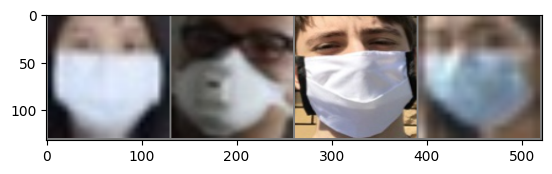

Ground-truth: ['Wearing Mask Correctly', 'Wearing Mask Correctly', 'Wearing Mask Correctly', 'Wearing Mask Correctly']


In [ ]:
# Code taken from lecture 07
import torchvision
import matplotlib.pyplot as plt
import numpy as np

classes = ['Not Wearing Mask', 'Wearing Mask Correctly', 'Wearing Mask Improperly']
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize: back to range [0, 1] just for showing the images
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))     # Reshape: C, H, W -> H, W, C
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images and print labels
imshow(torchvision.utils.make_grid(images))
first_labels = [classes[label] for label in labels]
print('Ground-truth:', first_labels)

In [ ]:
# We are defining our CNN architecture here
# code dapted from Tutrial 7
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Images are RGB
        self.conv1 = nn.Conv2d(3, 6, 5)  # Input: 3 (RGB), Output: 6 feature maps, Filter size: 5x5
        self.pool = nn.MaxPool2d(2, 2)   # Pooling layer: 2x2 window, stride 2
        self.conv2 = nn.Conv2d(6, 16, 5) # Input: 6, Output: 16, Filter size: 5x5


        # Fully connected layers:
        self.fc1 = nn.Linear(16 * 29 * 29, 120) # Input: 16*29*29, Output: 120
        self.fc2 = nn.Linear(120, 84)          # Input: 120, Output: 84


        # The final layer's output is 3, corresponding to the number of labels
        self.fc3 = nn.Linear(84, 3)            # For 3 classes: Not Wearing, Correctly Wearing, Improperly Wearing

    def forward(self, x):
        # Define the forward pass
        x = self.pool(F.relu(self.conv1(x)))  # Apply conv1 -> ReLU -> pool
        x = self.pool(F.relu(self.conv2(x)))  # Apply conv2 -> ReLU -> pool
        x = x.view(-1, 16 * 29 * 29)          # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))               # Apply fc1 -> ReLU
        x = F.relu(self.fc2(x))               # Apply fc2 -> ReLU
        x = self.fc3(x)                       # Apply fc3
        return x



In [ ]:
net = Net()

import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)
# transfer network to GPU
net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=13456, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)

In [ ]:
net = Net()

In [ ]:
#Defining a function loss and optimizer
# Code taken from Tutorial 7
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# Training the CN
# Code taken from Tutorial 7
import time

t0 = time.time()

for epoch in range(2):  # loop over the training set two times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics (loss.item() returns the mean loss in the mini-batch)
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training: total time in seconds =', time.time() - t0)

[1,   100] loss: 0.037
[1,   200] loss: 0.026
[1,   300] loss: 0.021
[1,   400] loss: 0.022
[2,   100] loss: 0.013
[2,   200] loss: 0.014
[2,   300] loss: 0.013
[2,   400] loss: 0.010
Finished Training: total time in seconds = 33.069920778274536


In [ ]:
#Saving the model
path =os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'cnn_classifier.pth')
torch.save(net.state_dict(), path)

In [ ]:
# Loading the test set
test_dataset = CustomDataset(root_path='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
#Retrieving the saved model
path =os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'cnn_classifier.pth')
net = Net()
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# Testing on the Validation set.
# Estimate average accuracy
# Code taken from Lecture 7
correct = 0
total = 0
with torch.no_grad():             # Avoid backprop at test
    for data in val_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the validation images: {100 * correct / total}%")

Accuracy of the network on the validation images: 93.52818371607516%


In [ ]:
#Printing the accuracy of prediction for each class
# Code taken from Lecture 7
classes = ['No Mask', 'Mask', 'Mask Worn Improperly']

# Adjustments for three categories
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))

with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        # Handle variable batch sizes
        for i in range(labels.size(0)):  # Adjust the range to the batch size
            label = labels[i]
            class_correct[label] += c[i].item() if labels.size(0) > 1 else c.item()  # Adjust for batch size of 1
            class_total[label] += 1

# Print class-wise accuracy
for i in range(3):  # Adjust the range to the number of classes
    print(f"Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%")

Accuracy of No Mask: 94.44%
Accuracy of Mask: 96.44%
Accuracy of Mask Worn Improperly: 7.14%


In [ ]:
# Estimate average accuracy
# Code taken from Lecture 7
correct = 0
total = 0
with torch.no_grad():             # Avoid backprop at test
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the test images using the first CNN model: {100 * correct / total}%")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the network on the test images using the first CNN model: 92.35807860262008%


The accuracy of the class labelled 2, that stands for people wearing mask incorrectly is as low as 7.14%. This might be due to the class imbalance. In fact we saw earlier with the function print(Counter(labels)) that the class '2' has only 78 occurrences compared to 1940 samples of class '1' and 376 samples of class '0'. To try to make our model better, I want to apply some dynamic data augmentation specifically to the class '2'. By dynamic I mean that each time the DataLoader requests a batch of images, the __getitem__ method of  Customdataset is called. If an image from class 2 is in that batch, the augmentations are applied on-the-fly. Thus, the same image can appear differently in each epoch, depending on the random transformations applied.

In [ ]:
# For this part, it was consulted this page: https://pytorch.org/vision/stable/transforms.html
from torchvision import transforms

#General transformation
general_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert NumPy arrays (uint8) to PIL Image
    transforms.Resize((128, 128)),  # Resize the image
    transforms.ToTensor(),  # Convert the PIL Image to a tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize the tensor
])


augment_transform = transforms.Compose([
    # Augmentation transformations
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),

])

In [ ]:
#Modifiying slightly the CustomDataset to apply data augmentation to class '2'

from torchvision.transforms import ToPILImage
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_path, transform=None, augment_transform=None):
        self.images, self.labels = import_images_and_labels(root_path)
        self.transform = transform
        self.augment_transform = augment_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # First, apply general transformation to all images
        if self.transform:
            image = self.transform(image)

        # Then, for class 2, apply additional augmented transformations
        if label == 2 and self.augment_transform is not None:
            # Since image is now a tensor after general_transform, convert it back to PIL for augmentation
            # Note: Only necessary if augment_transform expects a PIL Image. If augment_transform works on tensors, this is not needed
            image = transforms.ToPILImage()(image)  # Convert tensor back to PIL Image
            image = self.augment_transform(image)  # Now apply the augment_transform

        # Ensure image is a tensor before returning (if augment_transform converted it to PIL)
        if not isinstance(image, torch.Tensor):
            image = transforms.ToTensor()(image)

        return image, label

In [ ]:
#Creating a CustomDataset instance

trainset = CustomDataset(
    'train',
    transform=general_transform,
    augment_transform=augment_transform
)

# DataLoader for the training set
train_loader = DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)






In [ ]:
# Training the CNN after applying data augmentation
import time

t0 = time.time()

for epoch in range(2):  # loop over the training set two times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics (loss.item() returns the mean loss in the mini-batch)
        running_loss += loss.item()
        if i % 100 == 99:    # print every 100 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training: total time in seconds =', time.time() - t0)

[1,   100] loss: 0.005
[1,   200] loss: 0.005
[1,   300] loss: 0.006
[1,   400] loss: 0.006
[1,   500] loss: 0.005
[2,   100] loss: 0.005
[2,   200] loss: 0.006
[2,   300] loss: 0.005
[2,   400] loss: 0.005
[2,   500] loss: 0.006
Finished Training: total time in seconds = 35.59559893608093


In [ ]:
#Saving the model
path =os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'cnn_classifier_augmented.pth')
torch.save(net.state_dict(), path)

In [ ]:
#Retrieving the saved model
path =os.path.join(GOOGLE_DRIVE_PATH, 'Models', 'cnn_classifier_augmented.pth')
net = Net()
net.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
test_dataset = CustomDataset(root_path='test', transform=general_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2)

In [ ]:
# Testing on the Testing set.
# Estimate average accuracy
correct = 0
total = 0
with torch.no_grad():             # Avoid backprop at test
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the test images using the augmented CNN model: {100 * correct / total}%")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the network on the test images using the augmented CNN model: 92.5764192139738%


In [ ]:

classes = ['No Mask', 'Mask', 'Mask Worn Improperly']

# Adjustments for three categories
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()

        # Handle variable batch sizes
        for i in range(labels.size(0)):  # Adjust the range to the batch size
            label = labels[i]
            class_correct[label] += c[i].item() if labels.size(0) > 1 else c.item()  # Adjust for batch size of 1
            class_total[label] += 1

# Print class-wise accuracy
for i in range(3):  # Adjust the range to the number of classes
    print(f"Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}%")

Accuracy of No Mask: 92.16%
Accuracy of Mask: 97.16%
Accuracy of Mask Worn Improperly: 0.00%


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


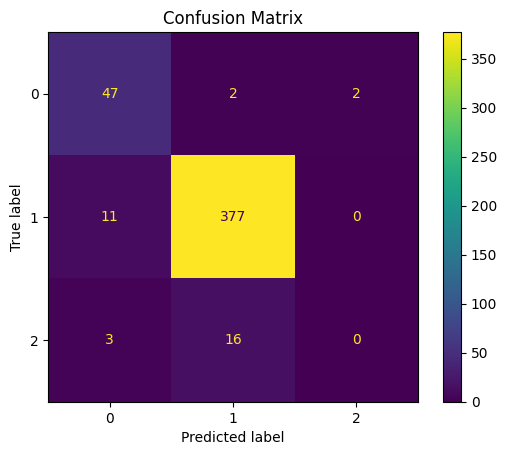

In [ ]:
#display of the confusio matrix

from sklearn.metrics import ConfusionMatrixDisplay

y_pred = []
y_val = []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)  # net is your trained model
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_val.extend(labels.cpu().numpy())

# Now display the confusion matrix
ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
plt.title('Confusion Matrix')
plt.show()